In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Normalize and transform to tensor type
transform = transforms.Compose([
    transforms.ToTensor()
])

# load MNIST
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.41MB/s]


In [3]:
def add_noise(inputs, noise_factor=0.5):
    noise = torch.randn_like(inputs) * noise_factor
    noisy = inputs+noise
    return torch.clip(noisy, 0., 1.)

In [4]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(), # turn 2D image (28×28) to 1D (784,)
            nn.Linear(28*28, 256), # Compress 784-dimension to 256-dimension
            nn.ReLU(),
            nn.Linear(256, 64) # The final latent vector's size is 64 --> z visualization
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256), # reconstruct in opposite direction of encoder
            nn.ReLU(),
            nn.Linear(256, 28*28), # 256-dimension to 784-dimension, reconstructing
            nn.Sigmoid(),  # raging [0,1](gray-scale image)
            nn.Unflatten(1, (1, 28, 28)) # reconstruct into original 1 channel (28, 28) image
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

##Exercise 1. PlainAutoEncoder Train with clean data, Evaluate with noisy data

In [5]:
def show_images(noisy_imgs, denoised_imgs, original_imgs=None, n=10):
    plt.figure(figsize=(18, 6))

    for i in range(n):
        # --- Noisy image ---
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Noisy", fontsize=12)
        if i == n // 2:
            plt.title("Input Image", fontsize=14)

        # --- Reconstructed image ---
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_imgs[i].squeeze().detach(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Denoised", fontsize=12)
        if i == n // 2:
            plt.title("Output Image", fontsize=14)

        if original_imgs is not None:
          # --- Original image ---
          plt.subplot(3, n, i + 1 + 2 * n)
          plt.imshow(original_imgs[i].squeeze(), cmap='gray')
          plt.axis('off')
          if i == 0:
              plt.ylabel("Original", fontsize=12)
          if i == n // 2:
              plt.title("Original Image", fontsize=14)

    plt.tight_layout()
    plt.show()

In [6]:
class PlainAutoencoder(DenoisingAutoencoder):  # Using the same structure
    pass

ae_model = PlainAutoencoder() # declare plain AE
ae_optimizer = optim.Adam(ae_model.parameters(), lr=1e-3)
ae_criterion = nn.MSELoss()

# Train with PlainAutoEncoder
for epoch in range(10):
    ae_model.train()
    for x, _ in train_loader:
        x_hat = ae_model(x)
        loss = ae_criterion(x_hat, x)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
    print(f"[AE] Epoch {epoch+1}, Loss: {loss.item():.4f}")

[AE] Epoch 1, Loss: 0.0173
[AE] Epoch 2, Loss: 0.0111
[AE] Epoch 3, Loss: 0.0080
[AE] Epoch 4, Loss: 0.0071
[AE] Epoch 5, Loss: 0.0065
[AE] Epoch 6, Loss: 0.0059
[AE] Epoch 7, Loss: 0.0051
[AE] Epoch 8, Loss: 0.0047
[AE] Epoch 9, Loss: 0.0039
[AE] Epoch 10, Loss: 0.0039


🔎 AE → Noisy input


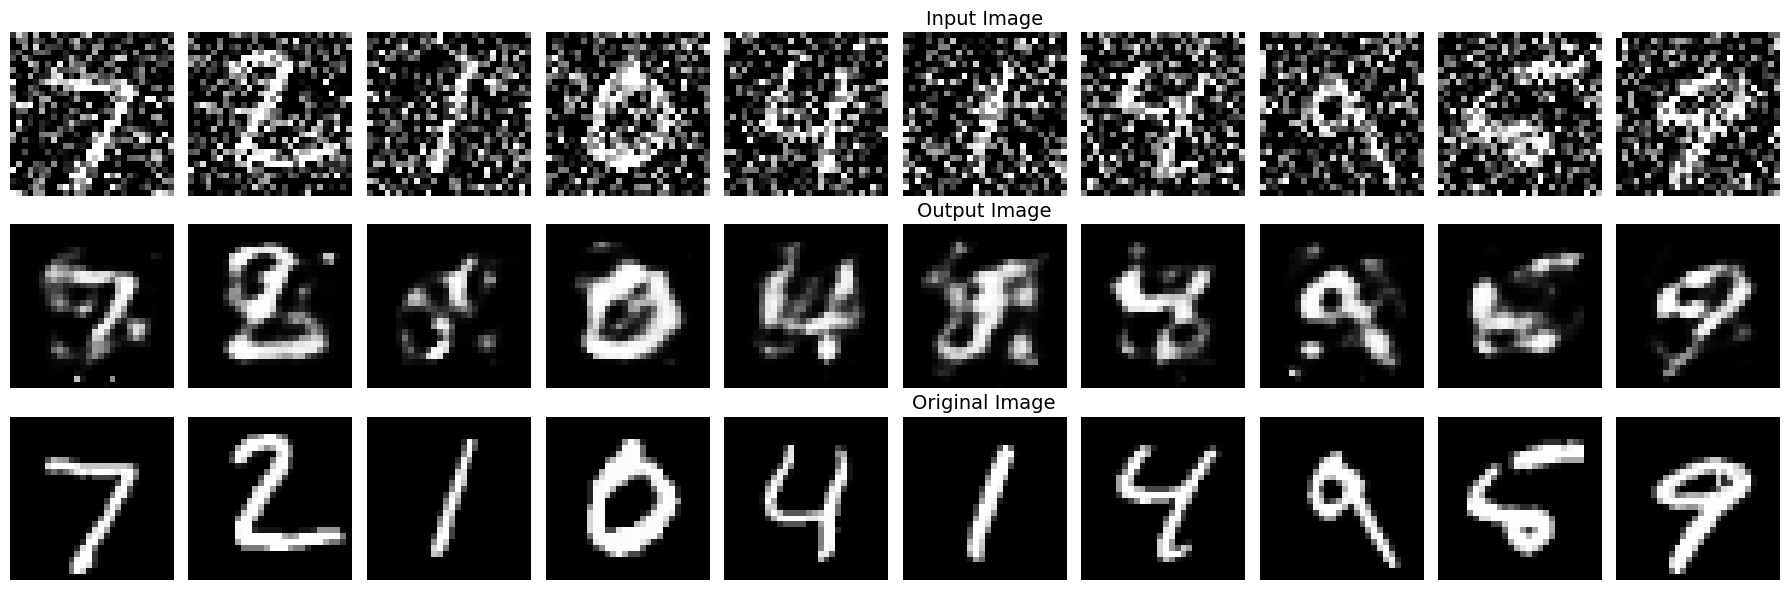

In [7]:
# Evauluate AE model: insert noise → Expect to fail in reconstruct
ae_model.eval()
for x, _ in test_loader:
    noisy_x = add_noise(x, 0.5)
    output = ae_model(noisy_x)
    print("🔎 AE → Noisy input")
    show_images(noisy_x[:10], output[:10], x[:10]) # Show first 10 images of noisy input image, reconstructed output image, original image)
    break

🔎 AE → Clean input


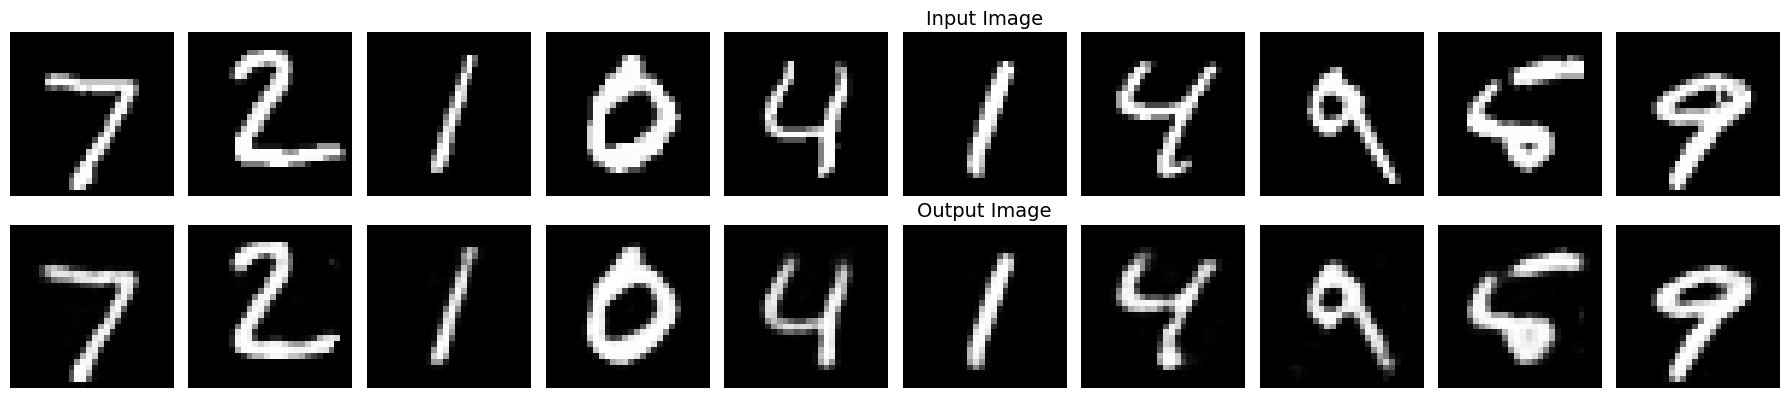

In [8]:
# # Evauluate AE model: without noise
ae_model.eval()
for x, _ in test_loader:
    output = ae_model(x)
    print("🔎 AE → Clean input")
    show_images(x[:10], output[:10]) # Show first 10 images of input image, output image)
    break

##실험 2. DenoisingAutoEncoder 훈련 시 노이즈 데이터, 평가 시 깨끗한 데이터 넣어보기

In [9]:
dae_model = DenoisingAutoencoder()
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
dae_criterion = nn.MSELoss()

for epoch in range(10):
    dae_model.train()
    for x, _ in train_loader:
        noisy_x = add_noise(x, 0.5) # Add noise to original input data
        x_hat = dae_model(noisy_x) # Train dae model using noisy input
        loss = dae_criterion(x_hat, x)

        dae_optimizer.zero_grad()
        loss.backward()
        dae_optimizer.step()
    print(f"[DAE] Epoch {epoch+1}, Loss: {loss.item():.4f}")

[DAE] Epoch 1, Loss: 0.0296
[DAE] Epoch 2, Loss: 0.0234
[DAE] Epoch 3, Loss: 0.0205
[DAE] Epoch 4, Loss: 0.0187
[DAE] Epoch 5, Loss: 0.0161
[DAE] Epoch 6, Loss: 0.0161
[DAE] Epoch 7, Loss: 0.0149
[DAE] Epoch 8, Loss: 0.0147
[DAE] Epoch 9, Loss: 0.0142
[DAE] Epoch 10, Loss: 0.0148


🔎 DAE → Noise input


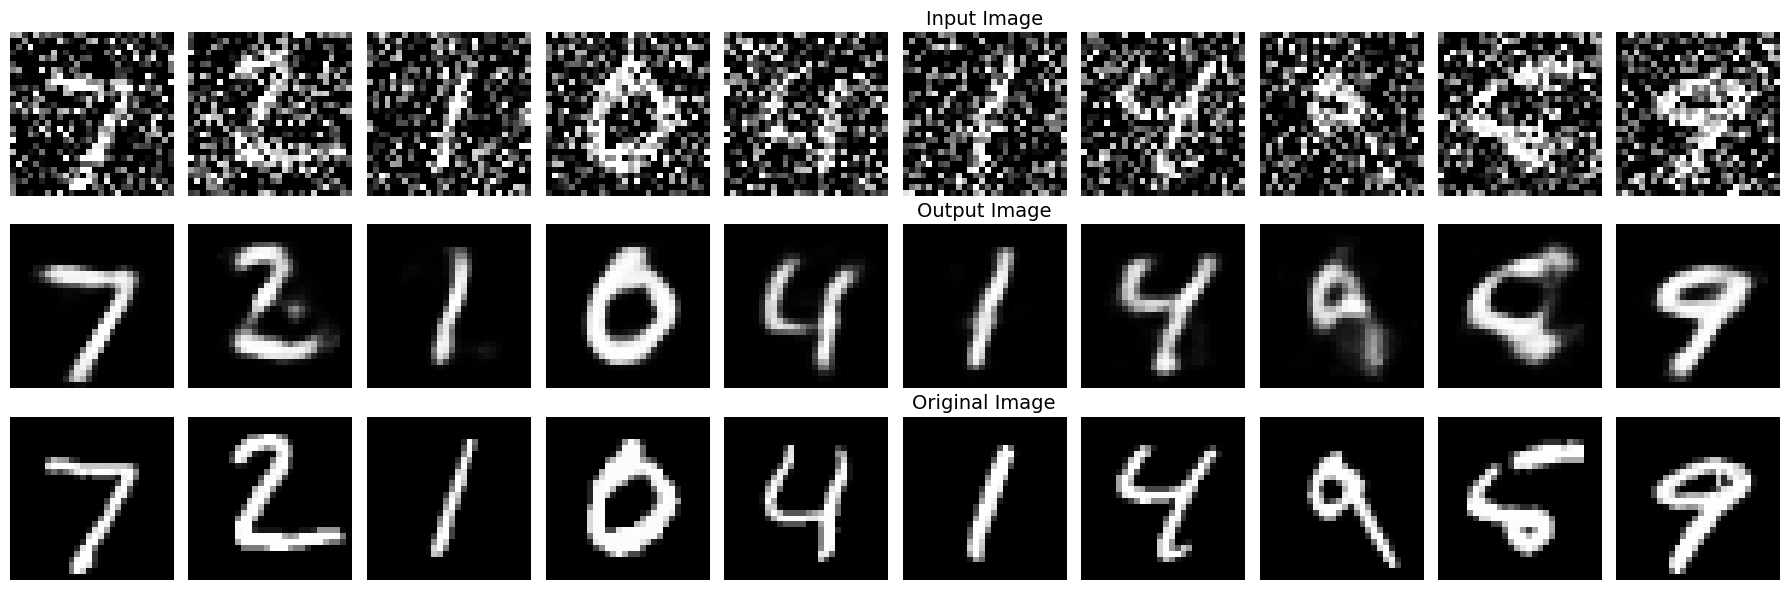

In [11]:
# Evaluate DAE model: Insert noisy data → Check for reconstruction availability
dae_model.eval()
for x, _ in test_loader:
    noisy_x = add_noise(x, 0.5)
    output = dae_model(noisy_x)  # Use noise data
    print("🔎 DAE → Noise input")
    show_images(noisy_x[:10], output[:10], x[:10]) # Show first 10 images of noisy input image, reconstructed output image, original image)
    break

🔎 DAE → Clean input


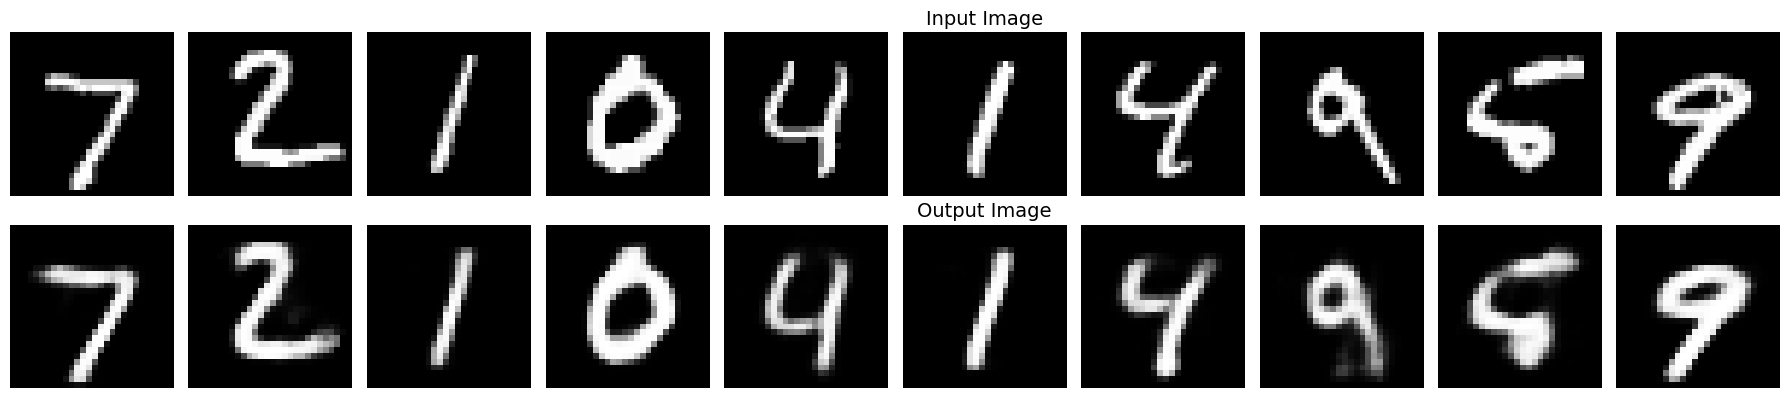

In [10]:
# Evaluate DAE model: Insert clean data → Check for reconstruction availability
dae_model.eval()
for x, _ in test_loader:
    output = dae_model(x)  # Use clean data
    print("🔎 DAE → Clean input")
    show_images(x[:10], output[:10]) # Show first 10 images of input image, output image)
    break

## 실험3 VariationalAutoEncoder

In [12]:
# ===== VAE Model =====
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=64):
        super(VAE, self).__init__()
        self.fc1=nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [13]:
# ===== Loss Function =====

# Loss function using MSE + KL Divergence
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)  # Use the nn.MSELoss module
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [15]:
# ===== Training =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

n_epochs = 10
for epoch in range(n_epochs):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)  # Flatten 28x28 -> 784
        optimizer.zero_grad()
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}] - Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch [1/10] - Loss: 50.2889
Epoch [2/10] - Loss: 38.8153
Epoch [3/10] - Loss: 35.6208
Epoch [4/10] - Loss: 34.0279
Epoch [5/10] - Loss: 33.0374
Epoch [6/10] - Loss: 32.3471
Epoch [7/10] - Loss: 31.8955
Epoch [8/10] - Loss: 31.5894
Epoch [9/10] - Loss: 31.3390
Epoch [10/10] - Loss: 31.1436


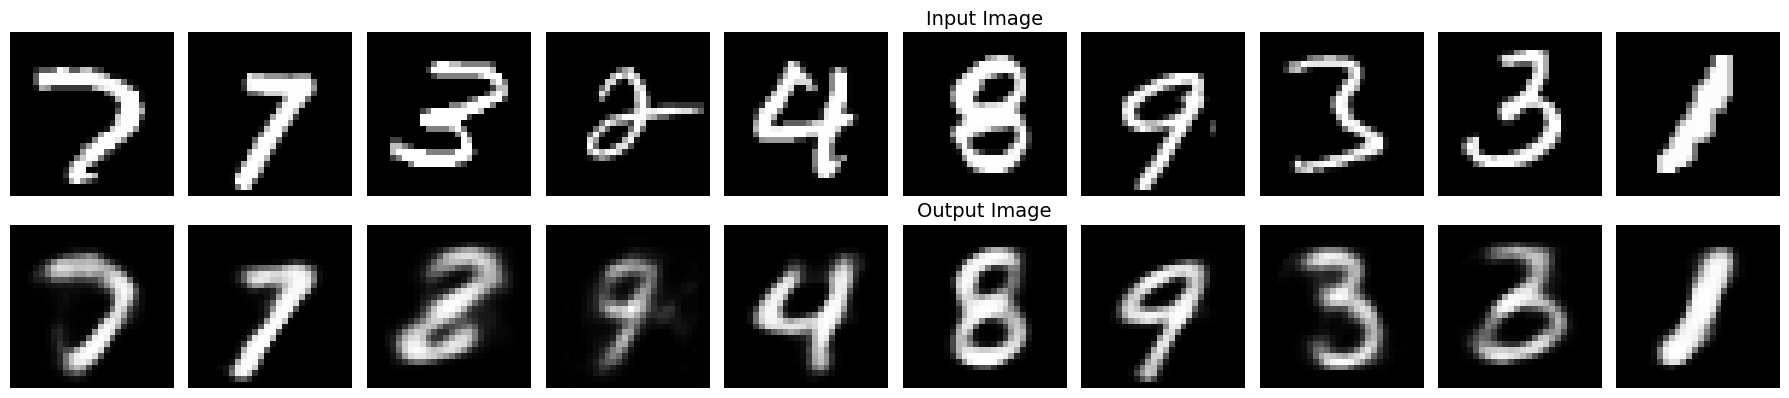

In [16]:
# ===== Visualize reconstructed images =====
vae.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x_input = x.view(-1, 784).to(device)
    recon, _, _ = vae(x_input)
    recon = recon.view(-1, 1, 28, 28).cpu()

    # Show original vs reconstructed
    show_images(x[:10], recon[:10]) # Show first 10 images of input image, output image)